In [9]:
import numpy as np
import tensorflow.contrib.slim as slim
import scipy.signal
import gym
import os
import threading
import multiprocessing
import tensorflow as tf
import ac_network
import worker
import matplotlib.pyplot as plt
import replay_buffer

reload(ac_network)
reload(worker)
reload(replay_buffer)

from ac_network import AC_Network
from worker import Worker
from replay_buffer import ReplayBuffer

** Setup of hyperparameters **

In [10]:
# Tensorboard dir
LOG_DIR = '/home/adrian/Schreibtisch/Uni/Data-Innovation-Lab/DILAB/tensorflowlogs'

# Gym environment
ENV_NAME = 'CartPole-v0'  # Discrete (4, 2)
RANDOM_SEED = 1234
STATE_DIM = 4
ACTION_DIM = 2

# Neural network spec
CELL_UNITS = 16
# Learning rate
LEARNING_RATE = 0.0005

# Exploration spec
ENTROPY_REGULARIZATION = True
ENTROPY_REGULARIZATION_LAMBDA = 0.1
# Noisy net settings 
# 1.Option --> None (normal fully connected layers)
# 2.Option --> "factorized"
# 3.Option --> "independent"
NOISE_DIST = 'factorized'

# Size of mini batches to run training on
MINI_BATCH = 40
REWARD_FACTOR = 0.001
# Discount rate for advantage estimation and reward discounting
GAMMA = 0.99
EPISODE_RUNS = 1000

METHOD = "PCL"
TAU = 0.2
ROLLOUT = 10

In [13]:
network_config = dict(shared = True,
                      shared_config = dict(kind = 'RNN',
                                           Cell_Units = 16),
                      policy_config = dict(layers = [2],
                                           noise_dist = "factorized"),
                      value_config = dict(layers = [1],
                                          noise_dist = "factorized"))

In [14]:
#MAIN
#def main(_):
global master_network
global global_episodes

tf.reset_default_graph()

with tf.device('/job:local/task:0/device:CPU:0'): #Parameter server adress
    RANDOM_SEED = 1234
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)

    global_episodes = tf.Variable(0, dtype=tf.int32, name='global_episodes', trainable=False)
    trainer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
    master_network = AC_Network(STATE_DIM, ACTION_DIM, 'global', None, network_config, tau = TAU, rollout = ROLLOUT, method = METHOD)  # Generate global network
    num_workers = 2  # Number of workers

    workers = []
    # Create worker classes
    with tf.device('/job:local/task:1/device:CPU:0'): #Worker server adresses
        workers.append(Worker(0, STATE_DIM, ACTION_DIM, network_config, trainer, global_episodes,
                              ENV_NAME, RANDOM_SEED, TAU, ROLLOUT, METHOD))
    with tf.device('/job:local/task:1/device:CPU:0'):
        workers.append(Worker(1, STATE_DIM, ACTION_DIM, network_config,trainer,global_episodes,
                              ENV_NAME, RANDOM_SEED, TAU, ROLLOUT, METHOD))

with tf.Session("grpc://localhost:2222") as sess:
    coord = tf.train.Coordinator()
    merged = tf.summary.merge_all()    
    train_writer = tf.summary.FileWriter(LOG_DIR, sess.graph)
    sess.run(tf.global_variables_initializer())

    # This is where the asynchronous magic happens.
    # Start the "work" process for each worker in a separate thread.
    worker_threads = []
    worker=workers[0]
    with tf.device('/job:local/task:1/device:CPU:0'):
        worker_work = lambda: worker.work(GAMMA, sess, coord, merged, train_writer)
        t = threading.Thread(target=(worker_work))
        t.start()
    worker_threads.append(t)
    worker=workers[1]
    with tf.device('/job:local/task:1/device:CPU:0'):
        worker_work = lambda: worker.work(GAMMA, sess, coord, merged, train_writer)
        t = threading.Thread(target=(worker_work))
        t.start()
    worker_threads.append(t)
    print("Start")
    coord.join(worker_threads)

#tf.app.run()


Start
Starting worker 1
Starting worker 0
('Reward: 22.0', ' | Episode', 0, ' of worker_0')
('Reward Online: 22.0', ' | Episode', 0, ' of worker_0')
('Reward: 17.0', ' | Episode', 0, ' of worker_1')
('Reward Online: 17.0', ' | Episode', 0, ' of worker_1')
('Reward: 9.0', ' | Episode', 20, ' of worker_0')
('Reward Online: 89.0', ' | Episode', 20, ' of worker_0')
('Reward: 72.0', ' | Episode', 20, ' of worker_1')
('Reward Online: 78.0', ' | Episode', 20, ' of worker_1')
('Reward: 20.0', ' | Episode', 40, ' of worker_0')
('Reward Online: 89.0', ' | Episode', 40, ' of worker_0')
('Reward: 25.0', ' | Episode', 40, ' of worker_1')
('Reward Online: 82.0', ' | Episode', 40, ' of worker_1')
('Reward: 33.0', ' | Episode', 60, ' of worker_0')
('Reward Online: 87.0', ' | Episode', 60, ' of worker_0')
('Reward: 19.0', ' | Episode', 60, ' of worker_1')
('Reward Online: 82.0', ' | Episode', 60, ' of worker_1')
('Reward: 15.0', ' | Episode', 80, ' of worker_0')
('Reward Online: 89.0', ' | Episode', 80

Exception in thread Thread-9:
Traceback (most recent call last):
  File "/home/adrian/anaconda3/envs/py27/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/home/adrian/anaconda3/envs/py27/lib/python2.7/threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "<ipython-input-14-4ecd63adf9a5>", line 38, in <lambda>
    worker_work = lambda: worker.work(GAMMA, sess, coord, merged, train_writer)
  File "worker.py", line 222, in work
    episodes = self.rolloutPCL(sess, s, rnn_state, episode_count = 1)
  File "worker.py", line 427, in rolloutPCL
    a, v, rnn_state, agent_info = self.act(s, rnn_state, sess)
  File "worker.py", line 168, in act
    self.local_AC.state_in[1]: rnn_state[1]})
  File "/home/adrian/anaconda3/envs/py27/lib/python2.7/site-packages/tensorflow/python/client/session.py", line 889, in run
    run_metadata_ptr)
  File "/home/adrian/anaconda3/envs/py27/lib/python2.7/site-packages/tensorflow/python/client/se

KeyboardInterrupt: 

Get rewards collected by the different agents

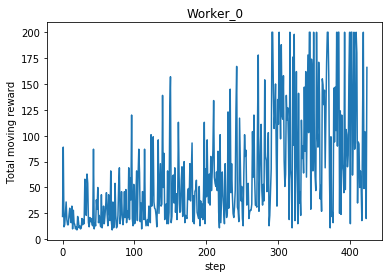

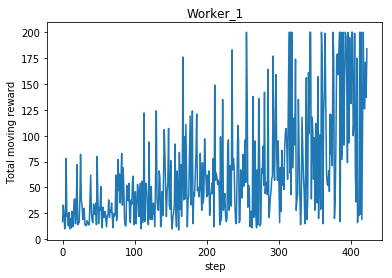

In [15]:
plotListNoNoisyNet = []
for i in range(len(workers)):
    workerTemp = workers[i]
    rewards = workerTemp.getRewards()
    plt.plot(np.arange(len(rewards)), rewards)
    plt.xlabel('step')
    plt.ylabel('Total moving reward')
    plt.title("Worker_%s" % i)
    plotListNoNoisyNet.append(plt)
    plt.show()

200.0


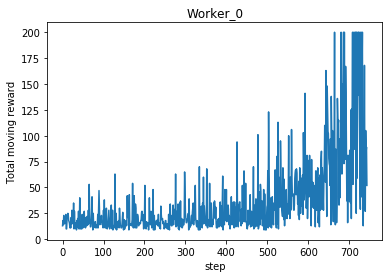

200.0


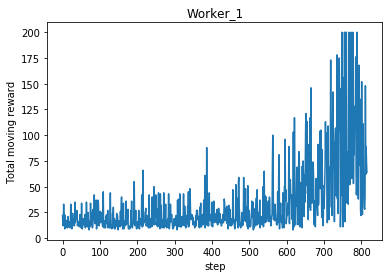

In [36]:
plotList = []
for i in range(len(workers)):
    workerTemp = workers[i]
    rewards = workerTemp.getRewards()
    print(np.max(rewards))
    plt.plot(np.arange(len(rewards)), rewards)
    plt.xlabel('step')
    plt.ylabel('Total moving reward')
    plt.title("Worker_%s" % i)
    plotList.append(plt)
    plt.show()